<a href="https://colab.research.google.com/github/hanrach/marked-beetle-analysis/blob/main/Graphs_and_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from matplotlib import axes
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading filenames which we will use for both original and threshcropped datasets

In [3]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")

train_images=[]
for filename in filenames:
    if 'light' not in filename:
      if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
dfmark=df[df['category']=='marked']
dfunmark=df[df['category']=='unmarked']


 **Section 1: Dataset statistics**

1. Distribution of categories in the dataset

In [61]:
df['category'].value_counts()

marked      479
unmarked    278
Name: category, dtype: int64

Text(240, 1, '278')

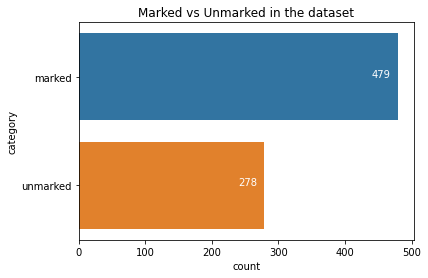

In [39]:
ax = sns.countplot(y='category', data=df)
ax.set(title='Marked vs Unmarked in the dataset')
ax.text(440,0, "479", color='white')
ax.text(240,1, "278", color='white')


2. Training and validation set stats

In [234]:
train_df1, validate_df1 = train_test_split(dfmark, test_size = 0.2, random_state = 42, stratify = dfmark['category'])
train_df1 = train_df1.reset_index(drop=True)
validate_df1 = validate_df1.reset_index(drop=True)
train_df2, validate_df2 = train_test_split(dfunmark, test_size = 0.2, random_state = 42, stratify = dfunmark['category'])
train_df2 = train_df2.reset_index(drop=True)
validate_df2 = validate_df2.reset_index(drop=True)
train_df=train_df1.append(train_df2)
validate_df=validate_df1.append(validate_df2)



In [235]:
train_df['category'].value_counts()

marked      383
unmarked    222
Name: category, dtype: int64

Text(190, 1, '222')

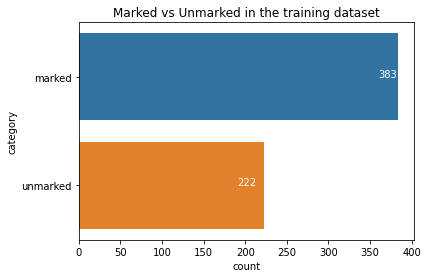

In [65]:
ax = sns.countplot(y='category', data=train_df)
ax.set(title='Marked vs Unmarked in the training dataset')
ax.text(360,0, "383", color='white')
ax.text(190,1, "222", color='white')

In [236]:
validate_df['category'].value_counts()

marked      96
unmarked    56
Name: category, dtype: int64

Text(50, 1, '56')

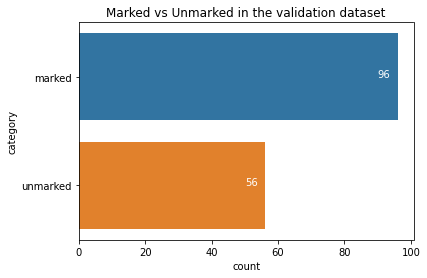

In [69]:
ax = sns.countplot(y='category', data=validate_df)
ax.set(title='Marked vs Unmarked in the validation dataset')
ax.text(90,0, "96", color='white')
ax.text(50,1, "56", color='white')

Summary of dataset statistics

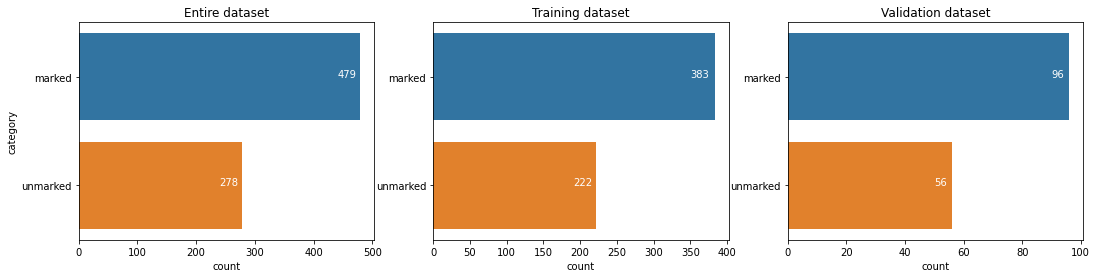

In [199]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,4), sharey=True)

#subplot 1
plt.subplot(1,3,1)
ax1= sns.countplot(y='category', data=df)
ax1.set_title('Entire dataset')
ax1.text(440,0, "479", color='white')
ax1.text(240,1, "278", color='white')
#subplot 2

plt.subplot(1,3,2)
ax2= sns.countplot(y='category', data=train_df)
ax2.set_title('Training dataset')
ax2.text(350,0, "383", color='white')
ax2.text(190,1, "222", color='white')
plt.ylabel(" ")


#subplot 3
plt.subplot(1,3,3)
ax3 = sns.countplot(y='category', data=validate_df)
ax3.set(title='Validation dataset')
ax3.text(90,0, "96", color='white')
ax3.text(50,1, "56", color='white')
plt.ylabel(" ")

#plt.suptitle('Marked vs Unmarked in datasets')
plt.show()

**Section 2: Batch visualization**

In [59]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 6))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(2, 4, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(2, 4, ind+5 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/GrayscaleThresholdBeetleImages", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        #plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.suptitle('Original images and their Threshcropped counterparts')

    plt.show()

In [47]:
tmp_df = df.sample(4)
tmp_df

,filename,category
452,NoPaperedGreen69v.tif,unmarked
662,PaperedMixed39v.tif,marked
330,PaperedControlTest81v.tif,marked
115,PaperedControl78d.tif,marked


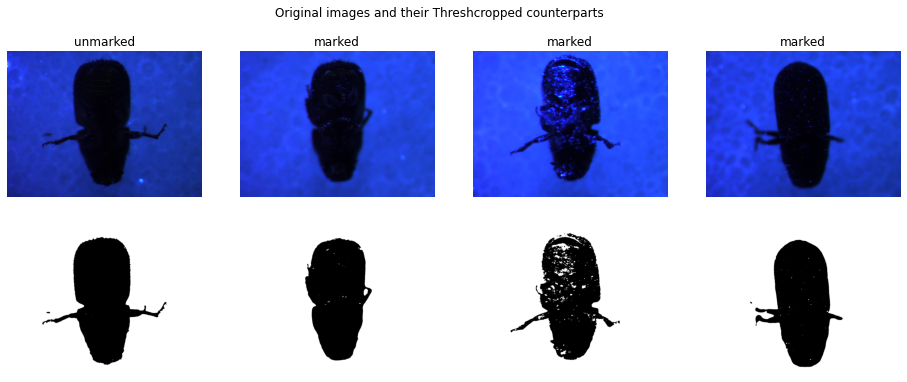

In [60]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

Overall metrics comparisons - with batch size 32 and image size 600 

**Section 3: Resnet finetuning - threshcropped**

1. Varying image size 

In [72]:
threshcrop_vary_image=pd.read_csv('/content/drive/MyDrive/fine_tuning/threshcropmetrics.txt')
threshcrop_vary_image

,IMAGE SIZE,VAL ACCURACY,PRECISION,RECALL,F1_SCORE
0,500,0.881579,0.890000,0.927083,0.908163
1,400,0.822368,0.834951,0.895833,0.864322
2,300,0.842105,0.882979,0.864583,0.873684
3,200,0.815789,0.809091,0.927083,0.864078
4,100,0.697368,0.812500,0.677083,0.738636
5,600,0.835526,0.890110,0.843750,0.866310


In [76]:
threshcrop_vary_image.dtypes


IMAGE SIZE         int64
 VAL ACCURACY    float64
 PRECISION       float64
 RECALL          float64
 F1_SCORE        float64
dtype: object

In [127]:
columns=threshcrop_vary_image.columns

In [119]:
columns[0]

'IMAGE SIZE'

In [120]:
threshcrop_vary_image=threshcrop_vary_image.sort_values(by=[columns[0]])

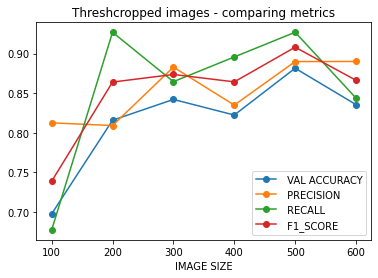

In [129]:
ax_im=plt.gca()
threshcrop_vary_image.plot(kind='line', x=columns[0], y=columns[1], style='o-',ax=ax_im)
threshcrop_vary_image.plot(kind='line', x=columns[0], y=columns[2], style='o-', ax=ax_im)
threshcrop_vary_image.plot(kind='line', x=columns[0], y=columns[3], style='o-', ax=ax_im)
threshcrop_vary_image.plot(kind='line', x=columns[0], y=columns[4], style='o-', ax=ax_im)
plt.title('Threshcropped images - comparing metrics')
plt.show()


Choosing image size on the basis of best F1 score

In [122]:
threshcrop_vary_image.loc[threshcrop_vary_image[columns[4]].idxmax()]

IMAGE SIZE       500.000000
 VAL ACCURACY      0.881579
 PRECISION         0.890000
 RECALL            0.927083
 F1_SCORE          0.908163
Name: 0, dtype: float64

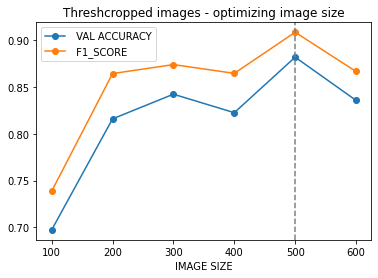

In [130]:
ax_im=plt.gca()
threshcrop_vary_image.plot(kind='line', x=columns[0], y=columns[1], style='o-', ax=ax_im)
threshcrop_vary_image.plot(kind='line', x=columns[0], y=columns[4], style='o-', ax=ax_im)
plt.axvline(x=500, color='gray', linestyle='--')

plt.title('Threshcropped images - optimizing image size')
plt.show()

2. Comparing batch size at image size = 500

In [95]:
threshcrop_vary_batchsize=pd.read_csv('/content/drive/MyDrive/fine_tuning/threshcropmetrics500.txt')
threshcrop_vary_batchsize

,BATCH SIZE,ACCURACY,PRECISION,RECALL,F1 SCORE
0,20,0.848684,0.884211,0.875000,0.879581
1,30,0.842105,0.833333,0.937500,0.882353
2,40,0.809211,0.946667,0.739583,0.830409
3,50,0.855263,0.930233,0.833333,0.879121


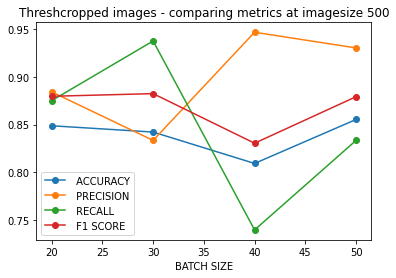

In [131]:
columns=threshcrop_vary_batchsize.columns
ax_im=plt.gca()
threshcrop_vary_batchsize.plot(kind='line', x=columns[0], y=columns[1], style='o-', ax=ax_im)
threshcrop_vary_batchsize.plot(kind='line', x=columns[0], y=columns[2], style='o-', ax=ax_im)
threshcrop_vary_batchsize.plot(kind='line', x=columns[0], y=columns[3], style='o-', ax=ax_im)
threshcrop_vary_batchsize.plot(kind='line', x=columns[0], y=columns[4], style='o-', ax=ax_im)
plt.title('Threshcropped images - comparing metrics at imagesize 500')
plt.show()

Choosing batchsize based on the best F1 score

In [116]:
threshcrop_vary_batchsize.loc[threshcrop_vary_batchsize[columns[4]].idxmax()]

BATCH SIZE    30.000000
 ACCURACY      0.842105
 PRECISION     0.833333
 RECALL        0.937500
 F1 SCORE      0.882353
Name: 1, dtype: float64

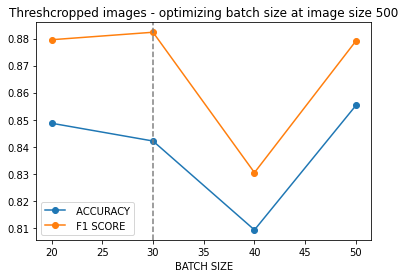

In [132]:
ax_b=plt.gca()
threshcrop_vary_batchsize.plot(kind='line', x=columns[0], y=columns[1], style='o-', ax=ax_b)
threshcrop_vary_batchsize.plot(kind='line', x=columns[0], y=columns[4], style='o-', ax=ax_b)
plt.axvline(x=30, color='gray', linestyle='--')

plt.title('Threshcropped images - optimizing batch size at image size 500')
plt.show()

Summarizing the threshcrop optimization process




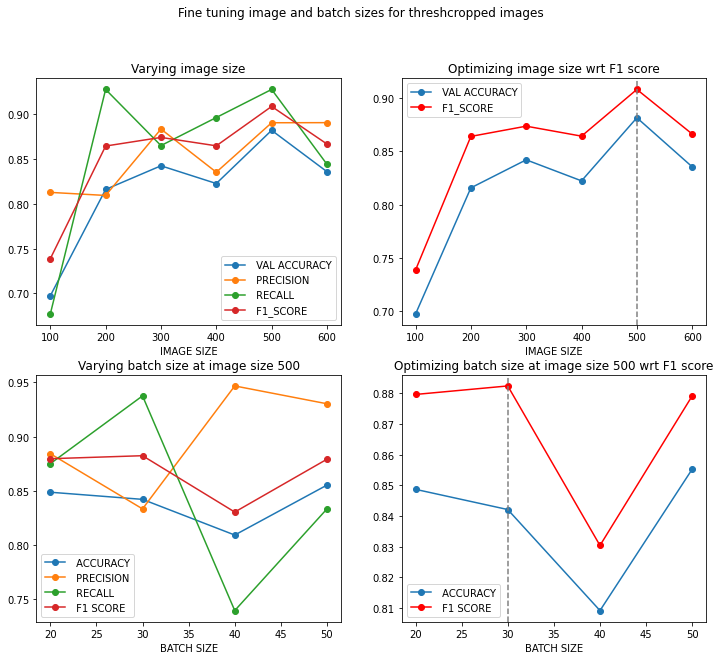

In [158]:
columns_im=threshcrop_vary_image.columns
columns_b=threshcrop_vary_batchsize.columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

#subplot 1
threshcrop_vary_image.plot(kind='line', x=columns_im[0], y=columns_im[1], style='o-',ax=axes[0,0])
threshcrop_vary_image.plot(kind='line', x=columns_im[0], y=columns_im[2], style='o-', ax=axes[0,0])
threshcrop_vary_image.plot(kind='line', x=columns_im[0], y=columns_im[3], style='o-', ax=axes[0,0])
threshcrop_vary_image.plot(kind='line', x=columns_im[0], y=columns_im[4], style='o-', ax=axes[0,0])
axes[0,0].set_title('Varying image size')

#subplot 2
threshcrop_vary_image.plot(kind='line', x=columns_im[0], y=columns_im[1], style='o-', ax=axes[0,1])
threshcrop_vary_image.plot(kind='line', x=columns_im[0], y=columns_im[4], style='ro-', ax=axes[0,1])
axes[0,1].axvline(x=500, color='gray', linestyle='--')
axes[0,1].set_title('Optimizing image size wrt F1 score')

#subplot 3
threshcrop_vary_batchsize.plot(kind='line', x=columns_b[0], y=columns_b[1], style='o-', ax=axes[1,0])
threshcrop_vary_batchsize.plot(kind='line', x=columns_b[0], y=columns_b[2], style='o-', ax=axes[1,0])
threshcrop_vary_batchsize.plot(kind='line', x=columns_b[0], y=columns_b[3], style='o-', ax=axes[1,0])
threshcrop_vary_batchsize.plot(kind='line', x=columns_b[0], y=columns_b[4], style='o-', ax=axes[1,0])
axes[1,0].set_title('Varying batch size at image size 500')

#subplot 4
threshcrop_vary_batchsize.plot(kind='line', x=columns_b[0], y=columns_b[1], style='o-', ax=axes[1,1])
threshcrop_vary_batchsize.plot(kind='line', x=columns_b[0], y=columns_b[4], style='ro-', ax=axes[1,1])
axes[1,1].axvline(x=30, color='gray', linestyle='--')
axes[1,1].set_title('Optimizing batch size at image size 500 wrt F1 score')

plt.suptitle('Fine tuning image and batch sizes for threshcropped images')
plt.show()





**Section 4: Resnet finetuning - original**




In [160]:
tvi=pd.read_csv('/content/drive/MyDrive/fine_tuning/metrics.txt')
tvi=tvi.sort_values(by=[tvi.columns[0]])
tvi

,Image size,Val_accuracy,Precision,Recall,F1 score
4,100,0.796053,0.901235,0.760417,0.824859
3,200,0.802632,0.823529,0.875000,0.848485
2,300,0.973684,0.969388,0.989583,0.979381
1,400,0.967105,0.969072,0.979167,0.974093
0,500,0.907895,0.901961,0.958333,0.929293


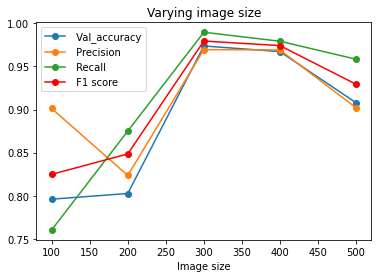

In [172]:
ax_im=plt.gca()
tvi.plot(kind='line', x=tvi.columns[0], y=tvi.columns[1], style='o-',ax=ax_im)
tvi.plot(kind='line', x=tvi.columns[0], y=tvi.columns[2], style='o-', ax=ax_im)
tvi.plot(kind='line', x=tvi.columns[0], y=tvi.columns[3], style='o-', ax=ax_im)
tvi.plot(kind='line', x=tvi.columns[0], y=tvi.columns[4], style='ro-', ax=ax_im)
ax_im.set_title('Varying image size')
plt.show()


Choosing best image size based on F1 score

In [163]:
tvi.loc[tvi[tvi.columns[4]].idxmax()]

Image size       300.000000
 Val_accuracy      0.973684
 Precision         0.969388
 Recall            0.989583
 F1 score          0.979381
Name: 2, dtype: float64

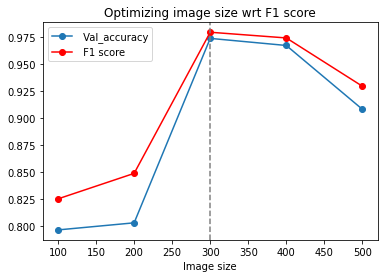

In [173]:
ax_im=plt.gca()
tvi.plot(kind='line', x=tvi.columns[0], y=tvi.columns[1], style='o-',ax=ax_im)
tvi.plot(kind='line', x=tvi.columns[0], y=tvi.columns[4], style='ro-', ax=ax_im)
ax_im.axvline(x=300, color='gray', linestyle='--')
ax_im.set_title('Optimizing image size wrt F1 score')
plt.show()

Varying batchsize based on the best image size 

In [206]:
tvb=pd.read_csv('/content/drive/MyDrive/fine_tuning/metrics_300.txt')
#tvb=tvb.drop(labels=[0,1], axis=0)
#tvb=tvb.sort_values(by=tvb.columns[0])
tvb

,BATCH SIZE,VAL ACCURACY,PRECISION,RECALL,F1 SCORE
0,10,0.947368,0.958333,0.958333,0.958333
1,20,0.815789,1.000000,0.708333,0.829268
2,30,0.868421,0.839286,0.979167,0.903846
3,32,0.947368,0.940000,0.979167,0.959184
4,35,0.901316,0.987952,0.854167,0.916201
5,40,0.947368,0.968085,0.947917,0.957895
6,50,0.881579,0.854545,0.979167,0.912621


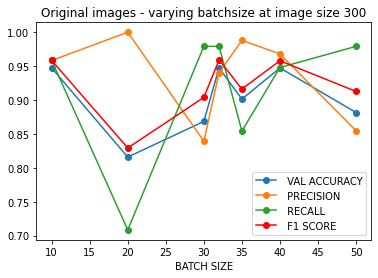

In [207]:
ax_im=plt.gca()
tvb.plot(kind='line', x=tvb.columns[0], y=tvb.columns[1], style='o-',ax=ax_im)
tvb.plot(kind='line', x=tvb.columns[0], y=tvb.columns[2], style='o-', ax=ax_im)
tvb.plot(kind='line', x=tvb.columns[0], y=tvb.columns[3], style='o-', ax=ax_im)
tvb.plot(kind='line', x=tvb.columns[0], y=tvb.columns[4], style='ro-', ax=ax_im)
ax_im.set_title('Original images - varying batchsize at image size 300')
plt.show()

Optimizing batchsize with respect to F1 score

In [208]:
tvb.loc[tvb[tvb.columns[4]].idxmax()]

BATCH SIZE       32.000000
 VAL ACCURACY     0.947368
 PRECISION        0.940000
 RECALL           0.979167
 F1 SCORE         0.959184
Name: 3, dtype: float64

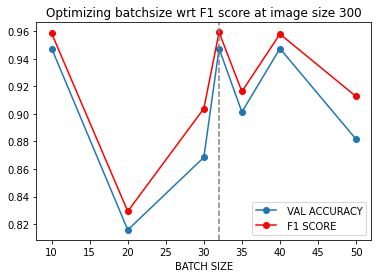

In [209]:
ax_im=plt.gca()
tvb.plot(kind='line', x=tvb.columns[0], y=tvb.columns[1], style='o-',ax=ax_im)
tvb.plot(kind='line', x=tvb.columns[0], y=tvb.columns[4], style='ro-', ax=ax_im)
ax_im.axvline(x=32,color='gray', linestyle='--')
ax_im.set_title('Optimizing batchsize wrt F1 score at image size 300')
plt.show()

Summary of fine tuning parameters for original images

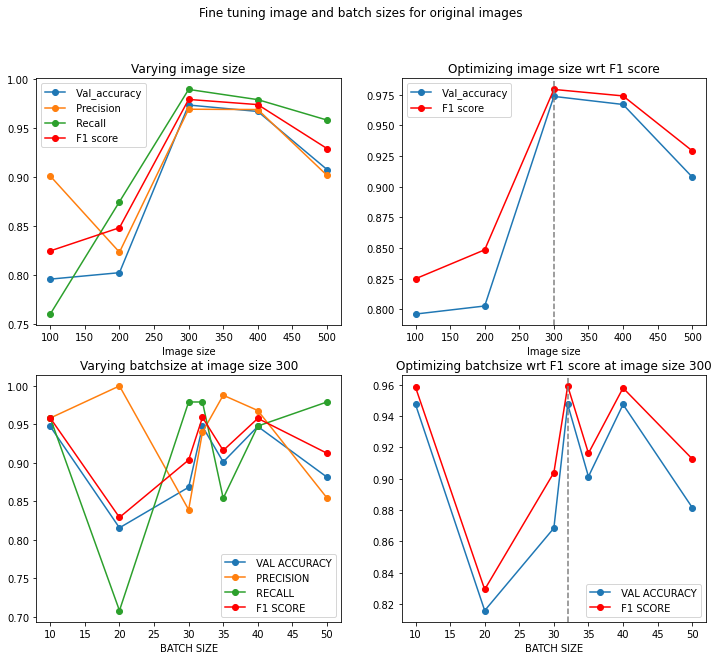

In [210]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

#subplot 1
tvi.plot(kind='line', x=tvi.columns[0], y=tvi.columns[1], style='o-',ax=axes[0,0])
tvi.plot(kind='line', x=tvi.columns[0], y=tvi.columns[2], style='o-', ax=axes[0,0])
tvi.plot(kind='line', x=tvi.columns[0], y=tvi.columns[3], style='o-', ax=axes[0,0])
tvi.plot(kind='line', x=tvi.columns[0], y=tvi.columns[4], style='ro-', ax=axes[0,0])
axes[0,0].set_title('Varying image size')

#subplot 2
tvi.plot(kind='line', x=tvi.columns[0], y=tvi.columns[1], style='o-',ax=axes[0,1])
tvi.plot(kind='line', x=tvi.columns[0], y=tvi.columns[4], style='ro-', ax=axes[0,1])
axes[0,1].axvline(x=300, color='gray', linestyle='--')
axes[0,1].set_title('Optimizing image size wrt F1 score')

#subplot 3
tvb.plot(kind='line', x=tvb.columns[0], y=tvb.columns[1], style='o-',ax=axes[1,0])
tvb.plot(kind='line', x=tvb.columns[0], y=tvb.columns[2], style='o-', ax=axes[1,0])
tvb.plot(kind='line', x=tvb.columns[0], y=tvb.columns[3], style='o-', ax=axes[1,0])
tvb.plot(kind='line', x=tvb.columns[0], y=tvb.columns[4], style='ro-', ax=axes[1,0])
axes[1,0].set_title('Varying batchsize at image size 300')

#subplot 4
tvb.plot(kind='line', x=tvb.columns[0], y=tvb.columns[1], style='o-',ax=axes[1,1])
tvb.plot(kind='line', x=tvb.columns[0], y=tvb.columns[4], style='ro-', ax=axes[1,1])
axes[1,1].axvline(x=32,color='gray', linestyle='--')
axes[1,1].set_title('Optimizing batchsize wrt F1 score at image size 300')

plt.suptitle('Fine tuning image and batch sizes for original images')
plt.show()





**Section 5: Best model with original and threshcropped**

1. Original 

In [212]:
IMG_SIZE = 300
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 32

test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )
test_generator1 = test_gen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 152 validated image filenames.


In [213]:
import keras
model_o = keras.models.load_model('/content/drive/MyDrive/fine_tuning/resnet50_original_300.h5')

In [215]:
to_samples=validate_df.shape[0]
predict = model_o.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))


In [237]:
validate_df['or_prediction'] = np.argmax(predict, axis=1)
validate_df["or_prediction"] = validate_df["or_prediction"].replace({1: 'unmarked', 0: 'marked'}) 
validate_df

,filename,category,or_prediction
0,PaperedTransparent22v.tif,marked,marked
1,PaperedTransparent88d.tif,marked,marked
2,PaperedTransparent97d.tif,marked,marked
3,PaperedMixed24d.tif,marked,marked
4,PaperedTransparent42d.tif,marked,marked
...,...,...,...
51,NoPaperedGreen76v.tif,unmarked,unmarked
52,NoPaperedGreen85d.tif,unmarked,unmarked
53,NoPaperedGreen16d.tif,unmarked,unmarked
54,NoPaperedMixed7v.tif,unmarked,unmarked


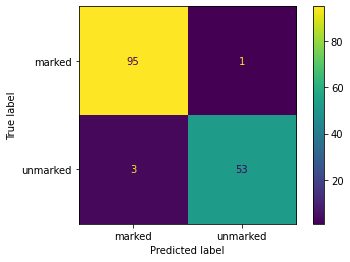

In [253]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(validate_df['category'])
y_pred=list(validate_df['or_prediction'])
cm_or=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_or, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")

In [274]:
tp=cm_or[0,0]
tn=cm_or[1,1]
fp = cm_or[1,0]
fn = cm_or[0,1]
precision = float(tp/(tp+fp))
recall = tp/(tp+fn)
f1_score = 2*precision*recall/(precision+recall)
accuracy = (tp+tn)/(tp+tn+fp+fn)
print("The Validation Accuracy is", accuracy)
print("The precision is ", precision)
print("The recall is ", recall)
print("The F1 score is ", f1_score)

The Validation Accuracy is 0.9736842105263158
The precision is  0.9693877551020408
The recall is  0.9895833333333334
The F1 score is  0.9793814432989691


In [275]:
f1_score_or=f1_score
val_acc_or=accuracy

2. Theshcropped

In [245]:
IMG_SIZE = 500
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 32
to_samples=validate_df.shape[0]

test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )
test_generator1 = test_gen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/GrayscaleThresholdBeetleImages/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 152 validated image filenames.


In [246]:
import keras
model_t = keras.models.load_model('/content/drive/MyDrive/fine_tuning/Resnet50_threshcropped_500.h5')

In [247]:
predict2 = model_t.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))


In [248]:
validate_df['th_prediction'] = np.argmax(predict2, axis=1)
validate_df["th_prediction"] = validate_df["th_prediction"].replace({1: 'unmarked', 0: 'marked'}) 
validate_df

,filename,category,or_prediction,th_prediction
0,PaperedTransparent22v.tif,marked,marked,marked
1,PaperedTransparent88d.tif,marked,marked,marked
2,PaperedTransparent97d.tif,marked,marked,marked
3,PaperedMixed24d.tif,marked,marked,marked
4,PaperedTransparent42d.tif,marked,marked,marked
...,...,...,...,...
51,NoPaperedGreen76v.tif,unmarked,unmarked,unmarked
52,NoPaperedGreen85d.tif,unmarked,unmarked,unmarked
53,NoPaperedGreen16d.tif,unmarked,unmarked,unmarked
54,NoPaperedMixed7v.tif,unmarked,unmarked,marked


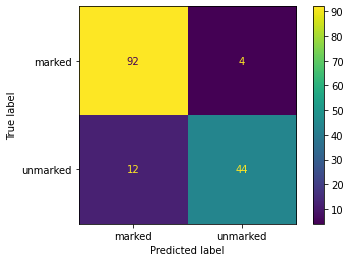

In [252]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true_t=list(validate_df['category'])
y_pred_t=list(validate_df['th_prediction'])
cm_t=confusion_matrix(y_true_t, y_pred_t, labels=["marked", "unmarked"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_t, display_labels=["marked", "unmarked"])
disp.plot(values_format="d")

In [276]:
tp=cm_t[0,0]
tn=cm_t[1,1]
fp = cm_t[1,0]
fn = cm_t[0,1]
precision = float(tp/(tp+fp))
recall = tp/(tp+fn)
f1_score = 2*precision*recall/(precision+recall)
accuracy = (tp+tn)/(tp+tn+fp+fn)
print("The Validation Accuracy is", accuracy)
print("The precision is ", precision)
print("The recall is ", recall)
print("The F1 score is ", f1_score)
f1_score_t=f1_score
val_acc_t=accuracy

The Validation Accuracy is 0.8947368421052632
The precision is  0.8846153846153846
The recall is  0.9583333333333334
The F1 score is  0.9199999999999999


Summaring best models from original and threshcropped images

In [288]:
models=pd.DataFrame({'Model':['Original', 'Threshcropped'], 'Validation accuracy':[val_acc_or, val_acc_t], 'F1 score': [f1_score_or, f1_score_t]})

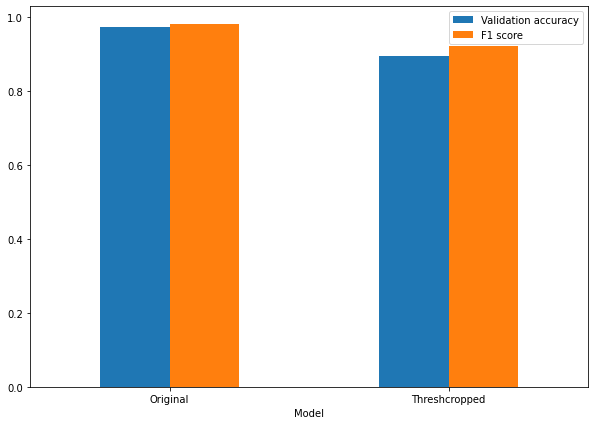

In [294]:
ax=models.plot.bar(x='Model', figsize=(10,7), rot=0)

**Conclusion: Use the trained model "model_o" for predictions.**